***Dataset from: http://insideairbnb.com/get-the-data.html***
        
***I choose Barcelona.***

In [1]:
import pandas as pd
import numpy as np
import os
from pathlib import Path
import sys
import re
from datetime import datetime
func = "../Function/"
sys.path.append(func)
from py_helper_functions import *


from patsy import dmatrices
from sklearn.model_selection import train_test_split
from mizani.formatters import percent_format
from plotnine import *
import matplotlib.pyplot as plt

from skranger.ensemble import RangerForestRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV
from sklearn.impute import SimpleImputer
from sklearn.inspection import permutation_importance
from sklearn.inspection import plot_partial_dependence
from sklearn.inspection import partial_dependence
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder

***Import the data which I want to used.***

In [2]:
bcn = pd.read_csv('../Data/listings.csv')

***Check whether the city has more than 10K rows of data***

In [3]:
len(bcn)

16206

In [4]:
bcn["property_type"].value_counts()

Entire rental unit                     7519
Private room in rental unit            5768
Entire serviced apartment               411
Entire loft                             279
Room in boutique hotel                  262
Entire condominium (condo)              260
Private room in condominium (condo)     242
Private room in residential home        222
Private room in hostel                  137
Room in hotel                           134
Private room in serviced apartment      129
Shared room in hostel                    90
Private room in bed and breakfast        83
Private room in guest suite              78
Entire residential home                  65
Room in hostel                           59
Private room in loft                     58
Shared room in rental unit               57
Entire guest suite                       40
Room in serviced apartment               32
Private room in casa particular          28
Boat                                     28
Private room                    

***keep if property type > 100***

In [5]:
bcn = bcn.loc[lambda x: x["property_type"].isin(["Entire rental unit", 
                                                 "Private room in rental unit", 
                                                 "Entire serviced apartment", 
                                                 "Entire loft", 
                                                 "Room in boutique hotel", 
                                                 "Entire condominium (condo)", 
                                                 "Private room in condominium (condo)", 
                                                 "Private room in residential home", 
                                                 "Private room in hostel", 
                                                 "Room in hotel", 
                                                 "Private room in serviced apartment",
                                                 "Shared room in hostel",
                                                 "Entire residential home", 
                                                 "Room in hostel",
                                                 "Private room in loft",
                                                 "Shared room in rental unit"
                                                ])]

***Re-classify the property type***

In [6]:
bcn["property_type"] = np.where(
    bcn["property_type"] == "Private room in rental unit", 
    "Entire rental unit", 
    bcn["property_type"]
)
bcn["property_type"] = np.where(
    bcn["property_type"] == "Entire loft", 
    "Entire serviced apartment", 
    bcn["property_type"]
)
bcn["property_type"] = np.where(
    bcn["property_type"] == "Room in boutique hotel", 
    "Room in hotel", 
    bcn["property_type"]
)
bcn["property_type"] = np.where(
    bcn["property_type"] == "Entire condominium (condo)", 
    "Entire serviced apartment", 
    bcn["property_type"]
)
bcn["property_type"] = np.where(
    bcn["property_type"] == "Private room in condominium (condo)", 
    "Entire serviced apartment", 
    bcn["property_type"]
)
bcn["property_type"] = np.where(
    bcn["property_type"] == "Private room in residential home", 
    "Entire serviced apartment", 
    bcn["property_type"]
)
bcn["property_type"] = np.where(
    bcn["property_type"] == "Private room in hostel", 
    "Room in hotel", 
    bcn["property_type"]
)
bcn["property_type"] = np.where(
    bcn["property_type"] == "Private room in serviced apartment", 
    "Entire serviced apartment", 
    bcn["property_type"]
)
bcn["property_type"] = np.where(
    bcn["property_type"] == "Shared room in hostel", 
    "Room in hotel", 
    bcn["property_type"]
)
bcn["property_type"] = np.where(
    bcn["property_type"] == "Entire residential home", 
    "Entire serviced apartment", 
    bcn["property_type"]
)
bcn["property_type"] = np.where(
    bcn["property_type"] == "Room in hostel", 
    "Room in hotel", 
    bcn["property_type"]
)
bcn["property_type"] = np.where(
    bcn["property_type"] == "Private room in loft", 
    "Entire serviced apartment", 
    bcn["property_type"]
)
bcn["property_type"] = np.where(
    bcn["property_type"] == "Shared room in rental unit", 
    "Entire rental unit", 
    bcn["property_type"]
)

***Rename the property type, make it shorter***

In [7]:
bcn["property_type"] = bcn["property_type"].map(
    {
        "Entire rental unit": "Rental unit",
        "Entire serviced apartment": "Apartment",
        "Room in hotel": "Hotel"
    }
)

***Property type as factor***

In [8]:
bcn["f_property_type"] = bcn["property_type"].astype("category")

In [9]:
bcn["property_type"].value_counts()

Rental unit    13344
Apartment       1666
Hotel            682
Name: property_type, dtype: int64

In [10]:
bcn["room_type"].value_counts()

Entire home/apt    8534
Private room       6813
Hotel room          198
Shared room         147
Name: room_type, dtype: int64

***Room type as factor***

In [11]:
bcn["f_room_type"] = bcn["room_type"].astype("category")

***Rename the room type, make it shorter***

In [12]:
bcn["f_room_type2"] = bcn["f_room_type"].map(
    {
        "Entire home/apt": "Entire/Apt",
        "Private room": "Private",
        "Hotel room": "Hotel",
        "Shared room": "Shared"
    }
)

In [13]:
pd.set_option('display.max_rows',None)
bcn.head(2).transpose()

,0,1
id,18674,23197
listing_url,https://www.airbnb.com/rooms/18674,https://www.airbnb.com/rooms/23197
scrape_id,20210910193102,20210910193102
last_scraped,2021-09-10,2021-09-11
name,Huge flat for 8 people close to Sagrada Familia,Forum CCIB DeLuxe★Spacious &Elegant★Large Balcony
description,110m2 apartment to rent in Barcelona. Located ...,"Beautiful spacious apartment, large terrace, 5..."
neighborhood_overview,Apartment in Barcelona located in the heart of...,Strategically located in the Parc del Fòrum ar...
picture_url,https://a0.muscache.com/pictures/13031453/413c...,https://a0.muscache.com/pictures/738532/806da1...
host_id,71615,90417
host_url,https://www.airbnb.com/users/show/71615,https://www.airbnb.com/users/show/90417


In [14]:
bcn["bathrooms_text"].value_counts()

1 bath               6252
1 shared bath        3113
2 baths              2623
1 private bath       1082
1.5 baths             685
1.5 shared baths      681
2 shared baths        521
3 baths               200
2.5 baths             108
4 baths                73
3 shared baths         53
2.5 shared baths       50
3.5 baths              32
0 shared baths         28
Private half-bath      27
5 baths                21
0 baths                20
Shared half-bath       18
3.5 shared baths       14
6 baths                14
11 shared baths        14
Half-bath              13
4 shared baths         10
4.5 baths               5
5.5 baths               4
8 baths                 3
7 shared baths          3
4.5 shared baths        2
7.5 baths               2
8 shared baths          2
16 baths                1
5 shared baths          1
7 baths                 1
7.5 shared baths        1
Name: bathrooms_text, dtype: int64

***Rename the bathrooms type***

In [15]:
bcn["bathrooms_text"] = np.where(
    bcn["bathrooms_text"] == "0 shared baths", 
    "0 baths", 
    bcn["bathrooms_text"]
)
bcn["bathrooms_text"] = np.where(
    bcn["bathrooms_text"] == "Private half-bath", 
    "Half-bath", 
    bcn["bathrooms_text"]
)
bcn["bathrooms_text"] = np.where(
    bcn["bathrooms_text"] == "Shared half-bath", 
    "Half-bath", 
    bcn["bathrooms_text"]
)
bcn["bathrooms_text"] = np.where(
    bcn["bathrooms_text"] == "1 shared bath", 
    "1 bath", 
    bcn["bathrooms_text"]
)
bcn["bathrooms_text"] = np.where(
    bcn["bathrooms_text"] == "1 private bath", 
    "1 bath", 
    bcn["bathrooms_text"]
)
bcn["bathrooms_text"] = np.where(
    bcn["bathrooms_text"] == "1.5 shared baths", 
    "1.5 baths", 
    bcn["bathrooms_text"]
)
bcn["bathrooms_text"] = np.where(
    bcn["bathrooms_text"] == "2 shared baths", 
    "2 baths", 
    bcn["bathrooms_text"]
)
bcn["bathrooms_text"] = np.where(
    bcn["bathrooms_text"] == "2.5 shared baths", 
    "2.5 baths", 
    bcn["bathrooms_text"]
)
bcn["bathrooms_text"] = np.where(
    bcn["bathrooms_text"] == "3 shared baths", 
    "3 baths", 
    bcn["bathrooms_text"]
)
bcn["bathrooms_text"] = np.where(
    bcn["bathrooms_text"] == "3.5 shared baths", 
    "3.5 baths", 
    bcn["bathrooms_text"]
)
bcn["bathrooms_text"] = np.where(
    bcn["bathrooms_text"] == "4 shared baths", 
    "4 baths", 
    bcn["bathrooms_text"]
)
bcn["bathrooms_text"] = np.where(
    bcn["bathrooms_text"] == "4.5 shared baths", 
    "4.5 baths", 
    bcn["bathrooms_text"]
)
bcn["bathrooms_text"] = np.where(
    bcn["bathrooms_text"] == "5 shared baths", 
    "5 baths", 
    bcn["bathrooms_text"]
)
bcn["bathrooms_text"] = np.where(
    bcn["bathrooms_text"] == "7 shared baths", 
    "7 baths", 
    bcn["bathrooms_text"]
)
bcn["bathrooms_text"] = np.where(
    bcn["bathrooms_text"] == "7.5 shared baths", 
    "7.5 baths", 
    bcn["bathrooms_text"]
)

In [16]:
bcn["bathrooms_text"].value_counts()

1 bath             10447
2 baths             3144
1.5 baths           1366
3 baths              253
2.5 baths            158
4 baths               83
Half-bath             58
0 baths               48
3.5 baths             46
5 baths               22
11 shared baths       14
6 baths               14
4.5 baths              7
7 baths                4
5.5 baths              4
8 baths                3
7.5 baths              3
8 shared baths         2
16 baths               1
Name: bathrooms_text, dtype: int64

In [17]:
bcn["bathrooms_text"] = bcn["bathrooms_text"].map(
    {
        "0 baths": "0 baths",
        "Half-bath": "0.5 bath",
        "1 bath": "1 bath",
        "1.5 baths": "1.5 baths",
        "2 baths": "2 baths",
        "2.5 baths": "2.5 baths",
        "3 baths": "3 baths",
        "3.5 baths": "3.5 baths",
        "4 baths": "4 baths",
        "4.5 baths": "4.5 baths",
        "5 baths": "5 baths",
        "5.5 baths": "5.5 baths",
        "6 baths": "6 baths",
        "7 baths": "7 baths",
        "7.5 baths": "7.5 baths",
        "8 baths": "8 baths",
        "11 shared baths": "11 baths",
        "16 baths": "16 baths",
    }
)

In [18]:
bcn["bathrooms_text"].value_counts()

1 bath       10447
2 baths       3144
1.5 baths     1366
3 baths        253
2.5 baths      158
4 baths         83
0.5 bath        58
0 baths         48
3.5 baths       46
5 baths         22
11 baths        14
6 baths         14
4.5 baths        7
7 baths          4
5.5 baths        4
8 baths          3
7.5 baths        3
16 baths         1
Name: bathrooms_text, dtype: int64

***Neighbourhood_cleansed as factors***

In [19]:
bcn["f_neighbourhood_cleansed"] = bcn["neighbourhood_cleansed"].astype("category")

***Create numerical variables***

In [20]:
bcn["bathrooms"].value_counts()

Series([], Name: bathrooms, dtype: int64)

In [21]:
del bcn["bathrooms"]

***rename bathrooms_text column***

In [22]:
bcn = bcn.rename(columns={"bathrooms_text":"bathrooms"})

In [23]:
bcn["usd_price_day"] = bcn["price"]
bcn["a_host_response_rate"] = bcn["host_response_rate"].fillna('0%').astype(str)
bcn["p_host_response_rate"] = bcn["a_host_response_rate"].apply(lambda x: x.replace(",","").replace("%","")).astype(int)/100

***The "price" variables and "bathrooms" variables are not pure numbers, such as "$121", "0 baths", I extracted the numbers***

In [24]:
bcn["price"] = bcn["price"].str.extract('(\d+)')
bcn["bathrooms"] = bcn["bathrooms"].str.extract('(\d+)')

***Add new numeric columns from certain columns***

In [25]:
numericals = [
    "accommodates",
    "bathrooms",
    "price",
    "review_scores_rating",
    "number_of_reviews",
    "reviews_per_month",
    "minimum_nights",
    "bedrooms",
    "beds"
]

for col in numericals:
    bcn["n_" + col] = pd.to_numeric(bcn[col], errors="coerce")

***Create days since first review***

In [26]:
bcn["n_days_since"] = (
    bcn.calendar_last_scraped.apply(lambda x: datetime.strptime(x, "%Y-%m-%d"))
    - bcn.first_review.fillna("1950-01-01").apply(
        lambda x: datetime.strptime(x, "%Y-%m-%d")
    )
).dt.days

bcn["n_days_since"] = np.where(bcn.first_review.isnull(), np.nan, bcn.n_days_since)

***Create dummy variables***

In [27]:
dummy_cols = [
              "host_is_superhost", 
              "host_has_profile_pic", 
              "host_identity_verified", 
              "has_availability", 
              "instant_bookable"
              ]

for col in dummy_cols:
    bcn[col] = bcn[col].map({'f': 0, 't': 1})
        
for col in dummy_cols:
    bcn["d_" + col] = pd.to_numeric(bcn[col], errors="coerce")

In [28]:
bcn = pd.concat(
    [
        bcn.filter(
            regex="^d_.*|^n_.*|^f_.*|^p_.*|^usd_.*",
        ),
        bcn[
            [
                "price",
                "id",
                "neighbourhood_cleansed",
                "room_type",
                "property_type",
            ]
        ],
    ],
    axis=1,
)

In [29]:
bcn.head(2).transpose()

,0,1
f_property_type,Rental unit,Rental unit
f_room_type,Entire home/apt,Entire home/apt
f_room_type2,Entire/Apt,Entire/Apt
f_neighbourhood_cleansed,la Sagrada Família,el Besòs i el Maresme
usd_price_day,$121.00,$229.00
p_host_response_rate,1,1
n_accommodates,8,6
n_bathrooms,2,2
n_price,121,229
n_review_scores_rating,4.4,4.74


In [30]:
bcn["price"] = bcn["price"].str.replace(",", "").astype(float)
bcn = bcn.loc[lambda x: x.price < 1000]

In [31]:
bcn = bcn.assign(
    n_accommodates2=lambda x: x["n_accommodates"] ** 2,
    ln_accommodates=lambda x: np.log(x["n_accommodates"]),
    ln_accommodates2=lambda x: np.log(x["n_accommodates"]) ** 2,
    ln_beds=lambda x: np.log(x["n_beds"]),
    ln_bedrooms=lambda x: np.log(x["n_bedrooms"]),
    ln_number_of_reviews=lambda x: np.log(x["n_number_of_reviews"] + 1),
)

/Users/chenche/miniconda3/lib/python3.8/site-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encountered in log


***Pool accomodations with 0,1,2,4,7,17 bathrooms***

In [32]:
bins = pd.IntervalIndex.from_tuples([(0, 1), (1, 2), (2, 4), (4, 7), (7, 17)], closed="left")
f_bathrooms = pd.cut(bcn["n_bathrooms"].to_list(), bins, labels=["0", "1", "2", "4", "7"])
f_bathrooms.categories = [0, 1, 2, 4, 7]
bcn["f_bathrooms"] = f_bathrooms

f_bathrooms.value_counts(dropna=False)

0        106
1      11813
2       3601
4        130
7         25
NaN       17
dtype: int64

***Pool num of reviews to 3 categories: none, 1-51 and >51***

In [33]:
bins = pd.IntervalIndex.from_tuples(
    [(0, 1), (1, 51), (51, max(bcn.n_number_of_reviews))], closed="left"
)
fnor = pd.cut(bcn["n_number_of_reviews"].to_list(), bins, labels=["0", "1", "2"])
fnor.categories = [0, 1, 2]
bcn["f_number_of_reviews"] = fnor
bcn["f_number_of_reviews"].value_counts(dropna=False)

1      8268
0      4243
2      3180
NaN       1
Name: f_number_of_reviews, dtype: int64

***Pool and categorize the number of minimum nights: 1,2,3,4,5,5+***

In [34]:
bins = pd.IntervalIndex.from_tuples(
    [(1, 2), (2, 3), (3, 4), (4, 5), (5, max(bcn.n_minimum_nights))], closed="left"
)
f_min_n = pd.cut(bcn["n_minimum_nights"].to_list(), bins, labels=["1", "2", "3", "4", "5"])
f_min_n.categories = [1, 2, 3, 4, 5]
bcn["f_minimum_nights"] = f_min_n
bcn["f_minimum_nights"].value_counts(dropna=False)

5      5251
1      4604
2      2801
3      2438
4       597
NaN       1
Name: f_minimum_nights, dtype: int64

***Change Infinite values with NaN***

In [35]:
bcn = bcn.replace([np.inf, -np.inf], np.nan)

***Check the missing variables***

In [36]:
to_filter = bcn.isna().sum()
to_filter[to_filter > 0]

n_bathrooms                   17
n_review_scores_rating      4243
n_reviews_per_month         4243
n_bedrooms                   529
n_beds                       296
n_days_since                4243
d_host_is_superhost           40
d_host_has_profile_pic        40
d_host_identity_verified      40
ln_accommodates                1
ln_accommodates2               1
ln_beds                      710
ln_bedrooms                  529
f_bathrooms                   17
f_number_of_reviews            1
f_minimum_nights               1
dtype: int64

***Solve the missing values issues***

*Drop if no target*

In [37]:
bcn = bcn.loc[lambda x: x.price.notnull()]

*Imput when few, not that important*

In [38]:
import numpy as np
bcn = bcn.assign(
    n_bathrooms = lambda x: x["n_bathrooms"].fillna(np.median(x["n_bathrooms"].dropna())),
    n_beds = lambda x: np.where(x["n_beds"].isnull(), x["n_accommodates"], x["n_beds"]),
    n_bedrooms = lambda x: np.where(x["n_bedrooms"].isnull(), np.ceil(x["n_accommodates"]/2), x["n_bedrooms"]),
    f_bathrooms = lambda x: x["f_bathrooms"].fillna(1),
    f_minimum_nights = lambda x: x["f_minimum_nights"].fillna(1),
    f_number_of_reviews = lambda x: x["f_number_of_reviews"].fillna(1),
    ln_beds = lambda x: x["ln_beds"].fillna(0),
    ln_bedrooms = lambda x: x["ln_bedrooms"].fillna(0),
    ln_accommodates = lambda x: x["ln_accommodates"].fillna(0),
    ln_accommodates2 = lambda x: x["ln_accommodates2"].fillna(0),
    d_host_is_superhost = lambda x: x["d_host_is_superhost"].fillna(0),
    d_host_has_profile_pic = lambda x: x["d_host_has_profile_pic"].fillna(0),
    d_host_identity_verified = lambda x: x["d_host_identity_verified"].fillna(0)
)

*Drop columns when many missing not important*

In [39]:
bcn = bcn.drop(["p_host_response_rate"], axis=1)

In [40]:
to_filter = bcn.isna().sum()
to_filter[to_filter > 0]

n_review_scores_rating    4243
n_reviews_per_month       4243
n_days_since              4243
dtype: int64

*Replace missing variables re reviews with zero, when no review + add flags*

In [41]:
bcn = bcn.assign(
    flag_days_since=np.multiply(bcn.n_days_since.isna(), 1),
    n_days_since=bcn.n_days_since.fillna(np.median(bcn.n_days_since.dropna())),
    flag_review_scores_rating=np.multiply(bcn.n_review_scores_rating.isna(), 1),
    n_review_scores_rating=bcn.n_review_scores_rating.fillna(
        np.median(bcn.n_review_scores_rating.dropna())
    ),
    flag_reviews_per_month=np.multiply(bcn.n_reviews_per_month.isna(), 1),
    n_reviews_per_month=bcn.n_reviews_per_month.fillna(
        np.median(bcn.n_reviews_per_month.dropna())
    ),
    flag_n_number_of_reviews=np.multiply(bcn.n_number_of_reviews.isna(), 1),
)

In [42]:
bcn.flag_days_since.value_counts()

0    11449
1     4243
Name: flag_days_since, dtype: int64

*redo features*

*Create variables, measuring the time since: squared, cubic, logs*

In [43]:
bcn = bcn.assign(
    ln_days_since=lambda x: np.log(x["n_days_since"] + 1),
    ln_days_since2=lambda x: np.log(x["n_days_since"] + 1) ** 2,
    ln_days_since3=lambda x: np.log(x["n_days_since"] + 1) ** 3,
    n_days_since2=lambda x: x["n_days_since"] ** 2,
    n_days_since3=lambda x: x["n_days_since"] ** 3,
    ln_review_scores_rating=lambda x: np.log(x["n_review_scores_rating"]),
)

/Users/chenche/miniconda3/lib/python3.8/site-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encountered in log


In [44]:
bcn.ln_days_since = bcn["ln_days_since"].fillna(0)
bcn.ln_days_since2 = bcn["ln_days_since2"].fillna(0)
bcn.ln_days_since3 = bcn["ln_days_since3"].fillna(0)

In [45]:
to_filter = bcn.isna().sum()
to_filter[to_filter > 0]

Series([], dtype: int64)

In [46]:
bcn.describe()

,n_accommodates,n_bathrooms,n_price,n_review_scores_rating,n_number_of_reviews,n_reviews_per_month,n_minimum_nights,n_bedrooms,n_beds,n_days_since,...,flag_days_since,flag_review_scores_rating,flag_reviews_per_month,flag_n_number_of_reviews,ln_days_since,ln_days_since2,ln_days_since3,n_days_since2,n_days_since3,ln_review_scores_rating
count,15692.000000,15692.000000,15692.000000,15692.000000,15692.000000,15692.000000,15692.000000,15692.000000,15692.000000,15692.000000,...,15692.000000,15692.000000,15692.000000,15692.0,15692.000000,15692.000000,15692.000000,1.569200e+04,1.569200e+04,1.569200e+04
mean,3.401351,1.283966,97.576408,4.543158,33.648483,1.028163,13.570673,1.669577,2.325835,1161.998917,...,0.270393,0.270393,0.270393,0.0,6.730389,46.457354,325.700251,1.836323e+06,3.496702e+09,-inf
std,2.216908,0.664985,99.129205,0.643257,66.490272,1.226628,33.046299,1.006377,1.901852,697.217463,...,0.444177,0.444177,0.444177,0.0,1.076702,12.212832,110.736529,2.070278e+06,5.963841e+09,NaN
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.010000,1.000000,0.000000,0.000000,1.000000,...,0.000000,0.000000,0.000000,0.0,0.693147,0.480453,0.333025,1.000000e+00,1.000000e+00,-inf
25%,2.000000,1.000000,40.000000,4.500000,0.000000,0.320000,1.000000,1.000000,1.000000,761.000000,...,0.000000,0.000000,0.000000,0.0,6.635947,44.035787,292.219127,5.791210e+05,4.407111e+08,1.504077e+00
50%,3.000000,1.000000,70.000000,4.670000,5.000000,0.690000,3.000000,1.000000,2.000000,1072.000000,...,0.000000,0.000000,0.000000,0.0,6.978214,48.695467,339.807377,1.149184e+06,1.231925e+09,1.541159e+00
75%,4.000000,1.000000,121.000000,4.810000,35.000000,1.190000,30.000000,2.000000,3.000000,1494.000000,...,1.000000,1.000000,1.000000,0.0,7.309881,53.434367,390.598893,2.232036e+06,3.334662e+09,1.570697e+00
max,16.000000,16.000000,999.000000,5.000000,853.000000,24.000000,1124.000000,16.000000,40.000000,3903.000000,...,1.000000,1.000000,1.000000,0.0,8.269757,68.388880,565.559415,1.523341e+07,5.945600e+10,1.609438e+00


***Export the processed Barcelona Airbnb data***

***Preparing data***

In [47]:
bcn.to_csv('../Output/Processed_Barcelona_Airbnb_data.csv', index=False)

In [48]:
data = bcn.loc[bcn.price.notna(), :]

In [49]:
def count_missing_values(df):
    return df.isna().sum()[df.isna().sum()>0]

In [50]:
count_missing_values(data)

Series([], dtype: int64)

***Since in this case, my task is:***

***help a company operating small and mid-size apartments hosting 2-6 guests***

***Thus, We focus on normal apartments, n<6***

In [51]:
data = data.query('n_accommodates < 7')

***Copy a variable***

In [52]:
data = data.assign(n_accommodates_copy = data.n_accommodates)
data1 = data

***Data statistical describe***

In [53]:
data.describe()

,n_accommodates,n_bathrooms,n_price,n_review_scores_rating,n_number_of_reviews,n_reviews_per_month,n_minimum_nights,n_bedrooms,n_beds,n_days_since,...,flag_review_scores_rating,flag_reviews_per_month,flag_n_number_of_reviews,ln_days_since,ln_days_since2,ln_days_since3,n_days_since2,n_days_since3,ln_review_scores_rating,n_accommodates_copy
count,14574.000000,14574.000000,14574.000000,14574.000000,14574.000000,14574.000000,14574.000000,14574.000000,14574.000000,14574.000000,...,14574.000000,14574.000000,14574.0,14574.000000,14574.000000,14574.000000,1.457400e+04,1.457400e+04,1.457400e+04,14574.000000
mean,2.985797,1.209002,88.168451,4.542937,32.914437,1.017838,14.172019,1.503362,2.009263,1155.742692,...,0.277275,0.277275,0.0,6.733225,46.462561,325.507372,1.808278e+06,3.408871e+09,-inf,2.985797
std,1.583471,0.556638,86.416829,0.652719,66.539888,1.234944,33.977701,0.747618,1.350418,687.437085,...,0.447669,0.447669,0.0,1.061279,12.048772,109.315084,2.032782e+06,5.831404e+09,NaN,1.583471
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.010000,1.000000,0.000000,0.000000,1.000000,...,0.000000,0.000000,0.0,0.693147,0.480453,0.333025,1.000000e+00,1.000000e+00,-inf,0.000000
25%,2.000000,1.000000,39.000000,4.520000,0.000000,0.300000,1.000000,1.000000,1.000000,762.000000,...,0.000000,0.000000,0.0,6.637258,44.053194,292.392417,5.806440e+05,4.424507e+08,1.508512e+00,2.000000
50%,2.000000,1.000000,63.000000,4.670000,4.000000,0.690000,3.000000,1.000000,2.000000,1072.000000,...,0.000000,0.000000,0.0,6.978214,48.695467,339.807377,1.149184e+06,1.231925e+09,1.541159e+00,2.000000
75%,4.000000,1.000000,113.000000,4.810000,32.000000,1.160000,30.000000,2.000000,3.000000,1485.000000,...,1.000000,1.000000,0.0,7.303843,53.346126,389.631740,2.205225e+06,3.274759e+09,1.570697e+00,4.000000
max,6.000000,11.000000,999.000000,5.000000,853.000000,24.000000,1124.000000,10.000000,16.000000,3903.000000,...,1.000000,1.000000,0.0,8.269757,68.388880,565.559415,1.523341e+07,5.945600e+10,1.609438e+00,6.000000


In [54]:
data.price.describe()

count    14574.000000
mean        88.168451
std         86.416829
min          0.000000
25%         39.000000
50%         63.000000
75%        113.000000
max        999.000000
Name: price, dtype: float64

In [55]:
data.f_room_type.value_counts()

Entire home/apt    7451
Private room       6794
Hotel room          195
Shared room         134
Name: f_room_type, dtype: int64

In [56]:
data.f_property_type.value_counts()

Rental unit    12371
Apartment       1542
Hotel            661
Name: f_property_type, dtype: int64

In [57]:
data.f_number_of_reviews.value_counts()

1    7664
0    4041
2    2869
Name: f_number_of_reviews, dtype: int64

***Linear regressions models***

In [58]:
import statsmodels.api as sm
import statsmodels.formula.api as smf

from stargazer import stargazer
from statsmodels.tools.eval_measures import mse,rmse
from sklearn.metrics import mean_squared_error

In [59]:
reg_model1 = smf.ols(formula="price~n_accommodates+n_beds+n_bedrooms+n_days_since+f_property_type+f_room_type+f_bathrooms+f_neighbourhood_cleansed", data = data).fit(cov_type="HC0")
reg_model2 = smf.ols(formula="price~n_accommodates+n_beds+n_bedrooms+n_days_since+f_property_type+f_room_type+f_bathrooms+f_neighbourhood_cleansed+n_number_of_reviews+flag_n_number_of_reviews+n_review_scores_rating+flag_review_scores_rating", data = data).fit(cov_type="HC0")
reg_model3 = smf.ols(formula="price~n_accommodates+n_beds+n_bedrooms+n_days_since+f_property_type+f_room_type+f_bathrooms+f_neighbourhood_cleansed+n_number_of_reviews+flag_n_number_of_reviews+n_review_scores_rating+flag_review_scores_rating+d_host_is_superhost+d_host_has_profile_pic+d_host_identity_verified+d_has_availability+d_instant_bookable", data = data).fit(cov_type="HC0")

In [60]:
models = [reg_model1, reg_model2,reg_model3]
AIC = [None]*len(models)
BIC = [None]*len(models)
RMSE = [None]*len(models)
Rsquared = [None]*len(models)
regr = [None]*len(models)
k = [None]*len(models)

for i in range(0,len(models)):
    AIC[i] = models[i].aic
    BIC[i] = models[i].bic
    RMSE[i] = rmse(models[i].fittedvalues, data.price) 
    Rsquared[i] = models[i].rsquared
    k[i] = (models[i].df_model)

In [61]:
evaluation_models = pd.DataFrame({'models':['(' + str(x+1) + ')'for x in range(len(models))],'k':k,'RSquared':Rsquared,'RMSE':RMSE,'BIC':BIC}).set_index('models')
evaluation_models

,k,RSquared,RMSE,BIC
models,,,,
(1),84.0,0.236892,75.487756,168209.206177
(2),87.0,0.242014,75.233990,168139.815624
(3),92.0,0.250989,74.787233,168014.146992


Export .csv file

In [62]:
evaluation_models.to_csv("../Output/evaluation_bcn_lr_models.csv")

***Cross Validation***

*Separate holdout set*

In [63]:
sample_size = round(0.2 * data1.shape[0])-1

In [64]:
np.random.seed(20211023)

In [65]:
data_work,data_holdout = train_test_split(data1, test_size = sample_size)

In [66]:
from sklearn.model_selection import KFold
n_folds = 5
k = KFold(n_splits = n_folds, shuffle = False, random_state = None)

In [67]:
def cross_validation_reg(formula, data, kfold, testdata, robustse = None):
    regression_list = []
    predicts_on_test = []
    rsquared = []
    rmse_list = []
    rmse_list_test = []

    for train_index, test_index in k.split(data):
        data_train, data_test = data.iloc[train_index, :], data.iloc[test_index, :]
        if robustse is None:
            model = smf.ols(formula, data = data_train).fit()
        else:
            model = smf.ols(formula, data = data_train).fit(cov_type = robustse)
        regression_list += [model]
        predicts_on_test += [model.predict(data_test)]
        rsquared += [model.rsquared]

        rmse_tr = pd.concat(
            [data_train["price"], model.predict(data_train)],
            axis=1,
            keys=["price", "predicted"],
        )
        rmse_tr = rmse_tr[~rmse_tr.isna().any(axis=1)]

        rmse_te = pd.concat(
            [data_test["price"], model.predict(data_test)],
            axis=1,
            keys=["price", "predicted"],
        )
        rmse_te = rmse_te[~rmse_te.isna().any(axis=1)]

        rmse_list += [rmse(rmse_tr["price"], rmse_tr["predicted"], axis = 0)]
        rmse_list_test += [rmse(rmse_te["price"], rmse_te["predicted"], axis = 0)]
    nvars = model.df_model

    return {
        "regressions": regression_list,
        "test_predict": predicts_on_test,
        "r2": rsquared,
        "rmse": rmse_list,
        "rmse_test": rmse_list_test,
        "nvars": nvars,
    }

In [68]:
def summarize_cv(cvlist, stat="rmse"):
    result = pd.DataFrame(
        {"Model" + str(x + 1): cvlist[x][stat] for x in range(len(cv_list))}
    )
    result["Resample"] = ["Fold" + str(x + 1) for x in range(len(cvlist[0]["rmse"]))]
    result = result.set_index("Resample")
    result = pd.concat([result, pd.DataFrame(result.mean(), columns=["Average"]).T])
    return result

In [69]:
cvm1 = cross_validation_reg("price~n_accommodates+n_beds+n_bedrooms+n_days_since+f_property_type+f_room_type+f_bathrooms+f_neighbourhood_cleansed", data1, k, "HC0")
cvm2 = cross_validation_reg("price~n_accommodates+n_beds+n_bedrooms+n_days_since+f_property_type+f_room_type+f_bathrooms+f_neighbourhood_cleansed+n_number_of_reviews+flag_n_number_of_reviews+n_review_scores_rating+flag_review_scores_rating", data1, k, "HC0")
cvm3 = cross_validation_reg("price~n_accommodates+n_beds+n_bedrooms+n_days_since+f_property_type+f_room_type+f_bathrooms+f_neighbourhood_cleansed+n_number_of_reviews+flag_n_number_of_reviews+n_review_scores_rating+flag_review_scores_rating+d_host_is_superhost+d_host_has_profile_pic+d_host_identity_verified+d_has_availability+d_instant_bookable", data1, k, "HC0")

In [70]:
cv_list = [cvm1, cvm2, cvm3]
z = summarize_cv(cv_list)
z

,Model1,Model2,Model3
Fold1,80.252594,80.053461,79.562587
Fold2,77.907988,77.648855,77.113372
Fold3,71.937226,71.676775,71.401679
Fold4,75.257173,75.017113,74.524655
Fold5,70.813336,70.528626,70.041764
Average,75.233663,74.984966,74.528811


In [71]:
print(z)
z.to_csv("../Output/bcn_cv_list.csv")

            Model1     Model2     Model3
Fold1    80.252594  80.053461  79.562587
Fold2    77.907988  77.648855  77.113372
Fold3    71.937226  71.676775  71.401679
Fold4    75.257173  75.017113  74.524655
Fold5    70.813336  70.528626  70.041764
Average  75.233663  74.984966  74.528811


***Random forest***

*Create train set and holdout set samples*

*Pick a smaller training set first so that models run faster and check if works*

In [72]:
data_train_set, data_holdout_set = train_test_split(data,train_size = 0.7, random_state = 42)

In [73]:
data_train_set.shape, data_holdout_set.shape

((10201, 45), (4373, 45))

*Basic Variables*

In [74]:
Basic = [
    "n_accommodates",
    "n_beds",
    "n_bedrooms",
    "n_days_since",
    "f_property_type",
    "f_room_type",
    "f_bathrooms",
    "f_neighbourhood_cleansed"
]

*Reviews Variables*

In [75]:
Reviews = [
    "n_number_of_reviews",
    "flag_n_number_of_reviews",
    "n_review_scores_rating",
    "flag_review_scores_rating"
]

*Creat dummy variables*

In [76]:
Dummy = [col for col in data if col.startswith("d_")]

In [77]:
X1 = [
    "n_accommodates:f_property_type",
    "f_room_type:f_property_type",
    "f_room_type:d_familykidfriendly",
    "d_host_is_superhost:f_property_type",
    "d_host_has_profile_pic:f_property_type",
    "d_host_identity_verified:f_property_type",
    "d_has_availability:f_property_type",
    "d_instant_bookable:f_property_type"
]

X2 = [
    "f_property_type:f_neighbourhood_cleansed",
    "f_room_type:f_neighbourhood_cleansed",
    "n_accommodates:f_neighbourhood_cleansed",
]

In [78]:
Predictors_1 = Basic
Predictors_2 = Basic + Reviews + Dummy
Predictors_E = Basic + Reviews + Dummy + X1 + X2

In [79]:
rfr = RangerForestRegressor(importance = "impurity",seed = 42)

tune_grid = {"mtry": [5, 7, 9], "min_node_size": [5, 10]}

rf_random = GridSearchCV(
    rfr,
    tune_grid,
    cv=5,
    scoring="neg_root_mean_squared_error",
    verbose=3,
)

y, X = dmatrices("price ~ " + " + ".join(Predictors_1), data_train_set)

rf_model_1 = rf_random.fit(X, y.ravel())

Fitting 5 folds for each of 6 candidates, totalling 30 fits
[CV 1/5] END .........min_node_size=5, mtry=5;, score=-69.879 total time=   0.4s
[CV 2/5] END .........min_node_size=5, mtry=5;, score=-79.749 total time=   0.5s
[CV 3/5] END .........min_node_size=5, mtry=5;, score=-62.889 total time=   0.4s
[CV 4/5] END .........min_node_size=5, mtry=5;, score=-74.111 total time=   0.4s
[CV 5/5] END .........min_node_size=5, mtry=5;, score=-67.677 total time=   0.4s
[CV 1/5] END .........min_node_size=5, mtry=7;, score=-68.978 total time=   0.5s
[CV 2/5] END .........min_node_size=5, mtry=7;, score=-79.006 total time=   0.5s
[CV 3/5] END .........min_node_size=5, mtry=7;, score=-62.128 total time=   0.6s
[CV 4/5] END .........min_node_size=5, mtry=7;, score=-73.459 total time=   0.6s
[CV 5/5] END .........min_node_size=5, mtry=7;, score=-66.821 total time=   0.6s
[CV 1/5] END .........min_node_size=5, mtry=9;, score=-68.660 total time=   0.7s
[CV 2/5] END .........min_node_size=5, mtry=9;, s

In [80]:
rfr = RangerForestRegressor(importance="impurity",seed = 42)

tune_grid = {"mtry": [8, 10, 12], "min_node_size": [5, 10, 15]}

rf_random = GridSearchCV(
    rfr,
    tune_grid,
    cv=5,
    scoring="neg_root_mean_squared_error",
    verbose=3,
)

y, X = dmatrices("price ~ " + " + ".join(Predictors_2), data_train_set)

rf_model_2 = rf_random.fit(X,y.ravel())

Fitting 5 folds for each of 9 candidates, totalling 45 fits
[CV 1/5] END .........min_node_size=5, mtry=8;, score=-67.146 total time=   0.6s
[CV 2/5] END .........min_node_size=5, mtry=8;, score=-77.295 total time=   0.6s
[CV 3/5] END .........min_node_size=5, mtry=8;, score=-59.590 total time=   0.6s
[CV 4/5] END .........min_node_size=5, mtry=8;, score=-70.717 total time=   0.6s
[CV 5/5] END .........min_node_size=5, mtry=8;, score=-64.894 total time=   0.7s
[CV 1/5] END ........min_node_size=5, mtry=10;, score=-66.747 total time=   0.8s
[CV 2/5] END ........min_node_size=5, mtry=10;, score=-77.021 total time=   0.7s
[CV 3/5] END ........min_node_size=5, mtry=10;, score=-59.054 total time=   0.7s
[CV 4/5] END ........min_node_size=5, mtry=10;, score=-70.418 total time=   0.7s
[CV 5/5] END ........min_node_size=5, mtry=10;, score=-64.048 total time=   0.7s
[CV 1/5] END ........min_node_size=5, mtry=12;, score=-66.270 total time=   0.8s
[CV 2/5] END ........min_node_size=5, mtry=12;, s

***Random forest RMSE by tuning parameters***

In [81]:
pd.DataFrame(rf_model_2.cv_results_)[
    ["param_mtry", "param_min_node_size", "mean_test_score"]
].assign(
    mean_test_score=lambda x: x["mean_test_score"] * -1,
    Variables=lambda x: x["param_mtry"],
    Min_nodes=lambda x: x["param_min_node_size"],
).pivot(
    index="Min_nodes", columns="Variables", values="mean_test_score"
).round(
    2
)

Variables,8,10,12
Min_nodes,,,
5,67.93,67.46,67.33
10,68.14,67.60,67.29
15,68.42,67.84,67.65


In [82]:
pd.DataFrame(
    {
        "Min vars": [rf_model_1.best_estimator_.mtry, rf_model_2.best_estimator_.mtry],
        "Min nodes": [
            rf_model_1.best_estimator_.min_node_size,
            rf_model_2.best_estimator_.min_node_size,
        ],
    },
    ["Model A", "Model B"],
)

,Min vars,Min nodes
Model A,9,5
Model B,12,10


In [83]:
z2 = pd.DataFrame(
    {
        "RMSE": [
            rf_model_1.cv_results_["mean_test_score"].min(),
            rf_model_2.cv_results_["mean_test_score"].min(),
        ]
    },
    ["Model A", "Model B"],
).round(3) * -1

In [84]:
print(z2)
z2.to_csv("../Output/bcn_rf.csv")

           RMSE
Model A  70.944
Model B  68.418


In [92]:
rf_model_2_var_imp_df = (
    pd.DataFrame(
        rf_model_2.best_estimator_.feature_importances_, X.design_info.column_names
    )
    .reset_index()
    .rename({"index": "varname",0: "imp"}, axis=1)
    .assign(imp_percentage=lambda x: x["imp"] / x["imp"].sum())
    .sort_values(by=["imp"], ascending=False)
)

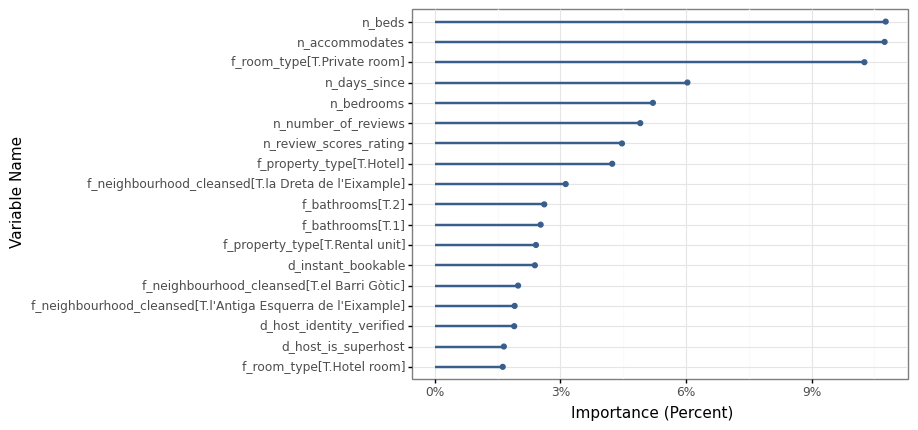

<ggplot: (8776902839950)>

In [93]:
cutoff = 600000

ggplot(
    rf_model_2_var_imp_df.loc[lambda x: x.imp > cutoff],
    aes(x="reorder(varname, imp)", y="imp_percentage"),
) + geom_point(color=color[0], size=1.5) + geom_segment(
    aes(x="varname", xend="varname", y=0, yend="imp_percentage"), color=color[0], size=1
) + ylab(
    "Importance (Percent)"
) + xlab(
    "Variable Name"
) + coord_flip() + scale_y_continuous(
    labels=percent_format()
) + theme_bw()

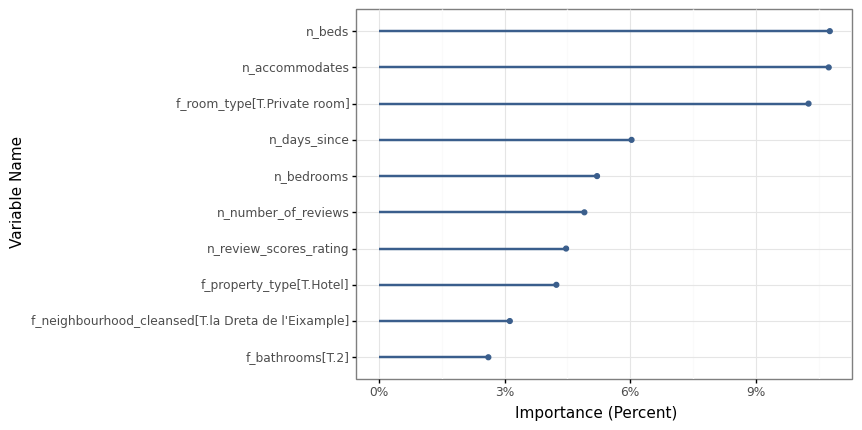

<ggplot: (8776824411489)>

In [94]:
ggplot(
    rf_model_2_var_imp_df.iloc[:10, :],
    aes(x="reorder(varname, imp)", y="imp_percentage"),
) + geom_point(color=color[0], size=1.5) + geom_segment(
    aes(x="varname", xend="varname", y=0, yend="imp_percentage"), color=color[0], size=1
) + ylab(
    "Importance (Percent)"
) + xlab(
    "Variable Name"
) + coord_flip() + scale_y_continuous(
    labels=percent_format()
) + theme_bw()

In [95]:
categorical_columns = [col for col in Predictors_2 if col.startswith("f_")]
numerical_columns = [col for col in Predictors_2 if col not in categorical_columns]

In [96]:
categorical_encoder = OneHotEncoder(handle_unknown="ignore")

preprocessing = ColumnTransformer(
    [
        ("cat", categorical_encoder, categorical_columns),
        ("num", "passthrough", numerical_columns),
    ]
)

rf = Pipeline(
    [("preprocess", preprocessing), ("regressor", rf_model_2.best_estimator_)] 
)

In [101]:
rf.fit(data_train_set[Predictors_2],data_train_set['price'])

TypeError: A sparse matrix was passed, but dense data is required. Use X.toarray() to convert to a dense numpy array.

***CART model***

In [85]:
from sklearn.tree import DecisionTreeClassifier

In [86]:
y, X = dmatrices("price ~ " + " + ".join(Predictors_2), data_train_set)

In [87]:
CART_model = DecisionTreeClassifier(random_state = 2021, criterion = "gini")

*Get potential ccp_alpha parameters*

In [88]:
path = CART_model.cost_complexity_pruning_path(X, y.ravel())
ccp_alphas, impurities = path.ccp_alphas, path.impurities

*Apply random search to select a "best" alpha*

In [89]:
CART_model_cv = RandomizedSearchCV(
    CART_model,
    {"ccp_alpha":ccp_alphas},
    cv = 5,
    scoring = "neg_root_mean_squared_error",
    verbose = 3,
)


CART_model_cv.fit(X,y.ravel())

Fitting 5 folds for each of 10 candidates, totalling 50 fits


/Users/chenche/miniconda3/lib/python3.8/site-packages/sklearn/model_selection/_split.py:666: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.


[CV 1/5] END .ccp_alpha=9.802960494069208e-05;, score=-92.045 total time=   0.3s
[CV 2/5] END .ccp_alpha=9.802960494069208e-05;, score=-86.446 total time=   0.3s
[CV 3/5] END .ccp_alpha=9.802960494069208e-05;, score=-83.022 total time=   0.3s
[CV 4/5] END .ccp_alpha=9.802960494069208e-05;, score=-89.140 total time=   0.3s
[CV 5/5] END .ccp_alpha=9.802960494069208e-05;, score=-86.194 total time=   0.3s
[CV 1/5] END ccp_alpha=0.00010842668425258368;, score=-92.046 total time=   0.3s
[CV 2/5] END ccp_alpha=0.00010842668425258368;, score=-86.444 total time=   0.3s
[CV 3/5] END ccp_alpha=0.00010842668425258368;, score=-82.706 total time=   0.3s
[CV 4/5] END ccp_alpha=0.00010842668425258368;, score=-89.122 total time=   0.3s
[CV 5/5] END ccp_alpha=0.00010842668425258368;, score=-86.178 total time=   0.3s
[CV 1/5] END .ccp_alpha=9.802960494069208e-05;, score=-92.045 total time=   0.3s
[CV 2/5] END .ccp_alpha=9.802960494069208e-05;, score=-86.446 total time=   0.3s
[CV 3/5] END .ccp_alpha=9.80

RandomizedSearchCV(cv=5, estimator=DecisionTreeClassifier(random_state=2021),
                   param_distributions={'ccp_alpha': array([0.00000000e+00, 3.50105732e-06, 6.68383670e-06, ...,
       1.56735149e-03, 1.73731957e-03, 3.86234264e-03])},
                   scoring='neg_root_mean_squared_error', verbose=3)

In [90]:
CART_rmse = pd.DataFrame(CART_model_cv.cv_results_).loc[
    lambda x: x.param_ccp_alpha == CART_model_cv.best_estimator_.ccp_alpha
].mean_test_score.values[0] * -1
CART_rmse

79.7424614681423

In [91]:
np.save("../Output/bcn_CART.npy", CART_rmse)